In [198]:
import pandas as pd
import numpy as np

In [200]:
data=pd.read_excel("C:/Users/SAWADOGO/Desktop/base.xlsx")

In [201]:
data.head()

,NIFU,DATE_IMMAT,END_DATE,ETAT_ARCHIV,REGIME,FORME_J_ABREGE,SEXE,Ville,Secteur_Activite,START_DATE
0,N10005,1970-08-21 04:20:28,2021-05-25 01:10:33,INACTIF,CME,Personne physique,Femme,Ouahigouya,Fabrication,2021-05-22 01:27:15
1,N100112,1970-08-22 08:06:51,2023-10-26 01:05:23,INACTIF,CME,Personne physique,Femme,Bobo-Dioulasso,Fabrication,2021-05-22 01:27:17
2,N100122,1970-08-22 08:08:28,2021-05-25 01:23:50,INACTIF,CME,Personne physique,Homme,Kaya,Autres,2021-05-22 01:27:17
3,N100193,1970-08-22 05:26:52,2021-05-25 01:21:37,INACTIF,CME,Personne physique,Femme,Bobo-Dioulasso,Fabrication,2021-05-22 01:27:17
4,N100348,1970-08-22 08:08:50,2099-12-31 00:00:00,INACTIF,CME,Personne physique,Femme,Ouagadougou,Autres,2021-05-22 01:27:17


#### verification preliminaire sur la base data

In [203]:
#statistique decriptive sur toutes les variables
data.describe()

,DATE_IMMAT,END_DATE,START_DATE
count,121382,121382,121382
mean,1970-08-22 12:10:07.722133436,2067-07-20 10:32:21.921389056,2021-11-23 13:20:11.085581312
min,1970-08-21 04:15:13,2021-05-21 01:26:41,2021-04-13 01:03:38
25%,1970-08-22 02:43:26,2021-05-25 01:24:40,2021-05-22 01:27:17
50%,1970-08-22 13:45:12,2099-12-31 00:00:00,2021-05-22 01:27:18
75%,1970-08-22 22:13:40,2099-12-31 00:00:00,2022-01-13 01:04:02
max,1970-08-23 06:21:56,2099-12-31 00:00:00,2024-07-29 14:49:39


In [204]:
#verification des variables manquantes
data.isnull().sum()

NIFU                0
DATE_IMMAT          0
END_DATE            0
ETAT_ARCHIV         0
REGIME              0
FORME_J_ABREGE      0
SEXE                0
Ville               0
Secteur_Activite    0
START_DATE          0
dtype: int64

## imputation de la variable duree de survie

### remplacer la date 2099-12-31 par des NA

In [207]:
data['END_DATE'] = data['END_DATE'].replace(pd.Timestamp('2099-12-31 00:00:00'), np.nan)

### imputation des valeurs manquantes de la variable END_DATE

In [209]:
# imputation des variables manquates
max_date = data['END_DATE'].max()

# Générer des valeurs aléatoires suivant une distribution normale (en jours)
# Moyenne = 1.5 jours, Écart type = 0.25 jours
np.random.seed(42)  # Pour reproductibilité
random_days = np.random.normal(loc=1.5, scale=0.25, size=data['END_DATE'].isna().sum())
random_days = np.clip(random_days, 1, 2)  # Limiter entre 1 et 2 jours

# Remplacer les NaN dans END_DATE
data.loc[data['END_DATE'].isna(), 'END_DATE'] = max_date + pd.to_timedelta(random_days, unit='D')


### calcul du temps de survie

In [211]:
# Conversion des colonnes en datetime
data['END_DATE'] = pd.to_datetime(data['END_DATE'])
data['START_DATE'] = pd.to_datetime(data['START_DATE'])

# Calcul de la durée en années
def calcul_age_annees(row):
    age = row['END_DATE'].year - row['START_DATE'].year
    if (row['END_DATE'].month, row['END_DATE'].day) < (row['START_DATE'].month, row['START_DATE'].day):
        age -= 1
    return age

data['Duree_Annees'] = data.apply(calcul_age_annees, axis=1)
# calcul de la duree en mois
def calcul_age_mois(row):
    delta_years = row['END_DATE'].year - row['START_DATE'].year
    delta_months = row['END_DATE'].month - row['START_DATE'].month
    total_months = delta_years * 12 + delta_months
    # Ajuster si le jour du mois END_DATE est avant celui de START_DATE
    if row['END_DATE'].day < row['START_DATE'].day:
        total_months -= 1
    return total_months

data['Duree_Mois'] = data.apply(calcul_age_mois, axis=1)



In [212]:
data.describe()

,DATE_IMMAT,END_DATE,START_DATE,Duree_Annees,Duree_Mois
count,121382,121382,121382,121382.000000,121382.000000
mean,1970-08-22 12:10:07.722133436,2023-04-18 08:25:43.909557760,2021-11-23 13:20:11.085581312,1.151340,16.368119
min,1970-08-21 04:15:13,2021-05-21 01:26:41,2021-04-13 01:03:38,0.000000,0.000000
25%,1970-08-22 02:43:26,2021-05-25 01:24:40,2021-05-22 01:27:17,0.000000,0.000000
50%,1970-08-22 13:45:12,2024-08-14 06:44:30.518083840,2021-05-22 01:27:18,0.000000,10.000000
75%,1970-08-22 22:13:40,2024-08-14 14:07:58.398728704,2022-01-13 01:04:02,3.000000,38.000000
max,1970-08-23 06:21:56,2024-08-15 01:00:35,2024-07-29 14:49:39,3.000000,40.000000
std,NaN,NaN,NaN,1.343629,16.680353


###  recodage des villes

In [214]:
data['Ville_rec'] = data['Ville'].map({
    'Ouagadougou': 'Grandes villes',
    'Bobo-Dioulasso': 'Grandes villes',
    'Ouahigouya': 'Villes moyennes',
    'Kaya': 'Villes moyennes',
    'Koudougou': 'Villes moyennes',
    'Banfora': 'Villes moyennes',
    'Tenkodogo': 'Villes moyennes',
    'Fada N\'Gourma': 'Petites villes et autres',
    'Dédougou': 'Petites villes et autres',
    'Autres': 'Petites villes et autres'
})

### verification des outliers pour la variables duree en mois

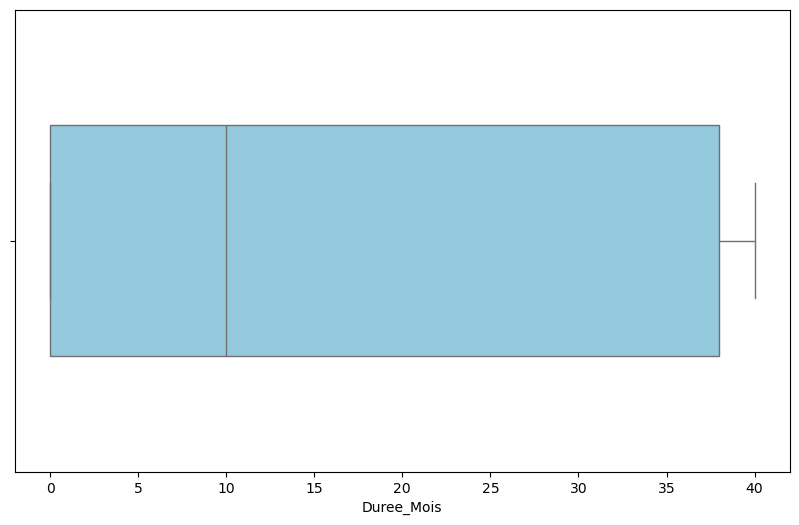

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création du boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=data, x='Duree_Mois', color='skyblue', width=0.5)

# Calcul des valeurs aberrantes
q1 = data['Duree_Mois'].quantile(0.25)  # 1er quartile
q3 = data['Duree_Mois'].quantile(0.75)  # 3ème quartile
iqr = q3 - q1  # Écart interquartile
lower_bound = q1 - 1.5 * iqr  # Limite inférieure
upper_bound = q3 + 1.5 * iqr  # Limite supérieure

# Filtrer les outliers
outliers = data[(data['Duree_Mois'] < lower_bound) | (data['Duree_Mois'] > upper_bound)]




### verification des valeurs aberrantes en fonction des caracteristiques

C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2950970578.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2950970578.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2950970578.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Lo

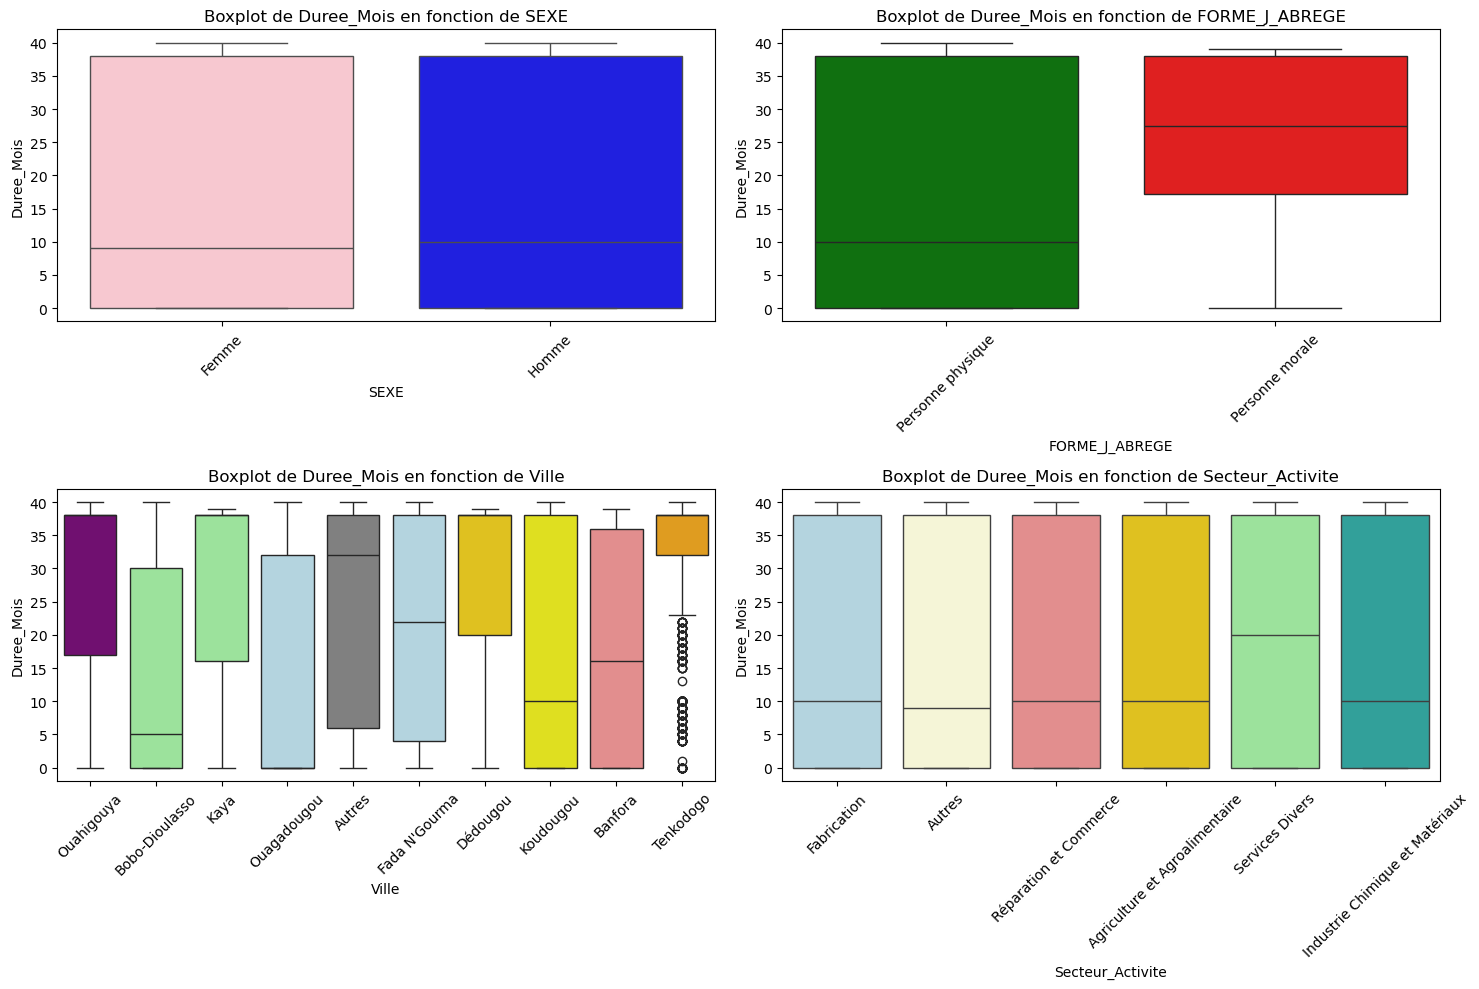

In [87]:
variables_categorielles = ['SEXE', 'FORME_J_ABREGE', 'Ville_', 'Secteur_Activite']
couleurs = {
    'SEXE': {'Homme': 'blue', 'Femme': 'pink'},  # Exemple : couleurs pour le sexe
    'FORME_J_ABREGE': {'Personne physique': 'green', 'Personne morale': 'red'},
    'Ville': {'Ouagadougou': 'lightblue', 'Bobo-Dioulasso': 'lightgreen', 'Koudougou': 'yellow', 'Banfora': 'lightcoral', 
              'Fada N\'Gourma': 'lightblue', 'Autres': 'gray', 'Kaya': 'lightgreen', 'Dédougou': 'gold', 
              'Ouahigouya': 'purple', 'Tenkodogo': 'orange'},
    'Secteur_Activite': {'Réparation et Commerce': 'lightcoral', 'Industrie Chimique et Matériaux': 'lightseagreen', 
                         'Autres': 'lightgoldenrodyellow', 'Fabrication': 'lightblue', 'Services Divers': 'lightgreen', 
                         'Agriculture et Agroalimentaire': 'gold'}
}

plt.figure(figsize=(15, 10))

for i, var in enumerate(variables_categorielles, 1):
    plt.subplot(2, 2, i)  # Créer un subplot (2x2)
    sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
    plt.title(f"Boxplot de Duree_Mois en fonction de {var}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### correction des valeurs abberrantes de la modalite Tenkodogo de la variable Ville

In [100]:
# Filtrer les données pour la modalité 'Tenkodogo'
tenkodogo_data = data[data['Ville'] == 'Tenkodogo']
# Identifier les valeurs aberrantes dans la variable 'Duree_Mois' pour Tenkodogo
outliers = tenkodogo_data[(tenkodogo_data['Duree_Mois'] < lower_bound) | (tenkodogo_data['Duree_Mois'] > upper_bound)]

# Afficher les outliers détectés
print("Valeurs aberrantes détectées pour 'Tenkodogo' :")
print(outliers)

# Remplacer les valeurs aberrantes par la médiane de 'Duree_Mois' pour 'Tenkodogo'
# (ou vous pouvez choisir une autre stratégie, comme la moyenne)
median_value = tenkodogo_data['Duree_Mois'].median()

# Remplacer les valeurs aberrantes
data.loc[data['Ville'] == 'Tenkodogo', 'Duree_Mois'] = data.loc[data['Ville'] == 'Tenkodogo', 'Duree_Mois'].apply(
    lambda x: median_value if x < lower_bound or x > upper_bound else x
)


Valeurs aberrantes détectées pour 'Tenkodogo' :
Empty DataFrame
Columns: [NIFU, DATE_IMMAT, END_DATE, ETAT_ARCHIV, REGIME, FORME_J_ABREGE, SEXE, Ville, Secteur_Activite, START_DATE, Duree_Annees, Duree_Mois]
Index: []


### boxplot apres correction des valeurs aberrantes

C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\3741086621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\3741086621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\3741086621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
C:\Users\SAWADOGO\AppData\Local

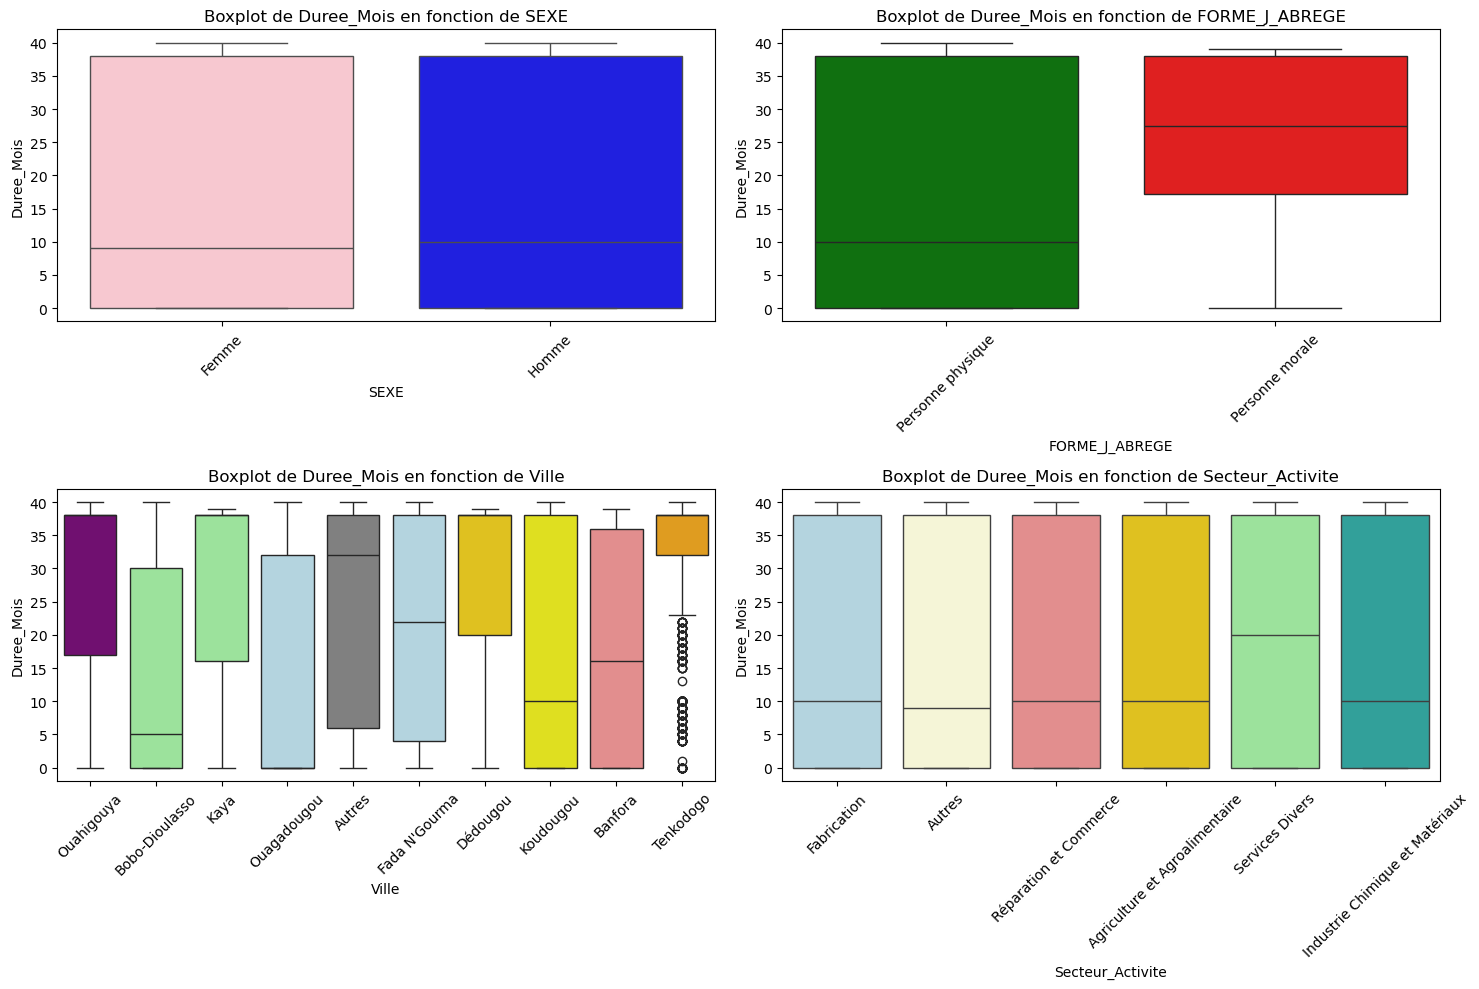

In [103]:
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables_categorielles, 1):
    plt.subplot(2, 2, i)  # Créer un subplot (2x2)
    sns.boxplot(x=var, y='Duree_Mois', data=data,palette=couleurs[var])
    plt.title(f"Boxplot de Duree_Mois en fonction de {var}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:

doublons=data.duplicated()
print(f"sommes des lignes en doubles:{doublons.sum()}",end=' ')

### evolution du taux de survie

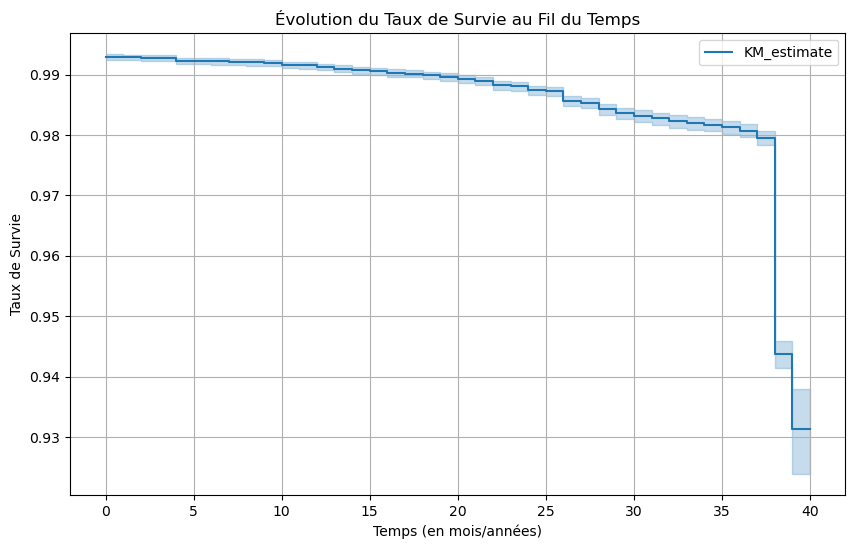

In [152]:
from lifelines import KaplanMeierFitter

survival_data = data[['Duree_Mois', 'ETAT_ARCHIV']]  # Assurez-vous que les colonnes existent
data['ETAT_ARCHIV_REC'] = survival_data['ETAT_ARCHIV'].apply(lambda x: 1 if x == 'INACTIF' else 0)

# Initialisation du modèle Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajustement du modèle sur les données
kmf.fit(data['Duree_Mois'], event_observed=data['ETAT_ARCHIV_REC'])

# Tracer la courbe de survie
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Évolution du Taux de Survie au Fil du Temps')
plt.xlabel('Temps (en mois/années)')
plt.ylabel('Taux de Survie')
plt.grid(True)
plt.show()

### Taux de survie en fonction des caractéristiques

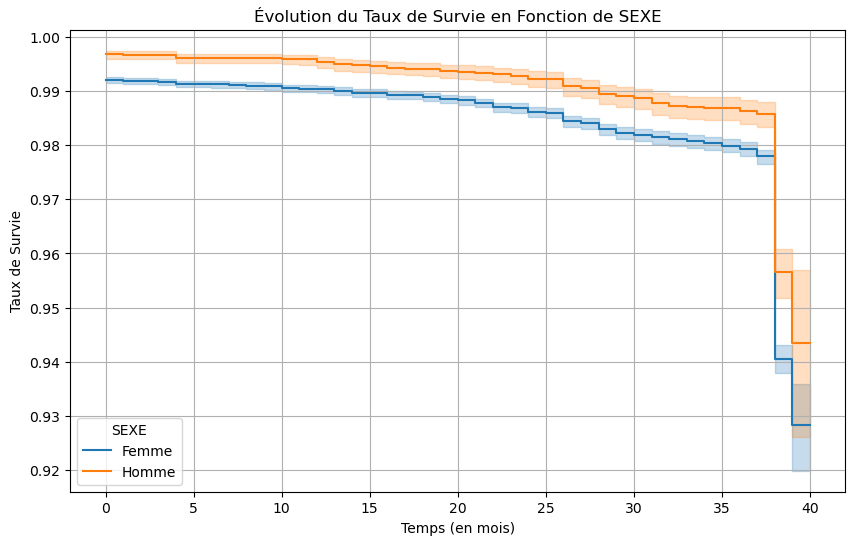

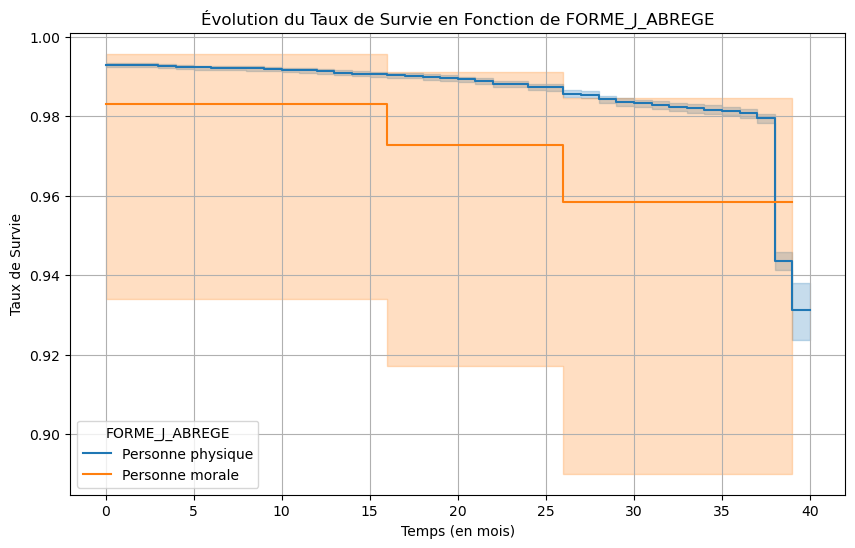

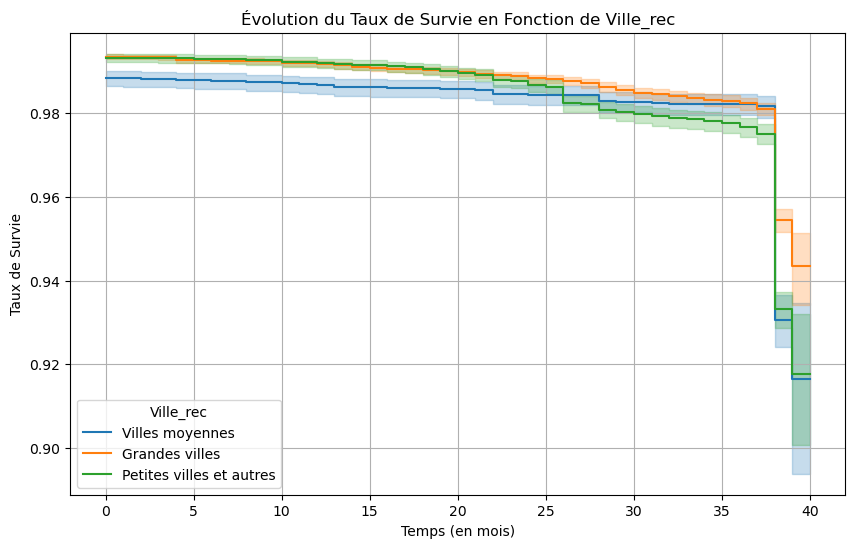

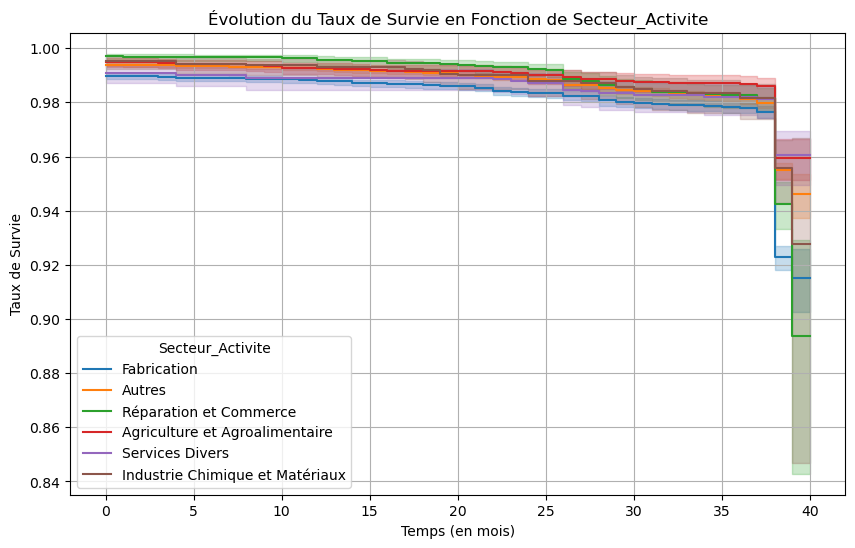

In [191]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Fonction pour tracer les courbes de survie pour une variable donnée
def plot_survival_by_category(data, category_col, duration_col='Duree_Mois', event_col='ETAT_ARCHIV_REC'):
    plt.figure(figsize=(10, 6))
    
    # Parcours des catégories uniques de la variable
    for category in data[category_col].unique():
        category_data = data[data[category_col] == category]
        
        # Ajustement du modèle Kaplan-Meier pour chaque catégorie
        kmf.fit(category_data[duration_col], event_observed=category_data[event_col])
        
        # Tracé de la courbe de survie pour cette catégorie
        kmf.plot_survival_function(label=category)
    
    # Personnalisation du graphique
    plt.title(f'Évolution du Taux de Survie en Fonction de {category_col}')
    plt.xlabel('Temps (en mois)')
    plt.ylabel('Taux de Survie')
    plt.legend(title=category_col)
    plt.grid(True)
    plt.show()

# Initialisation du modèle Kaplan-Meier
kmf = KaplanMeierFitter()

# Exemple d'utilisation : Tracer la courbe de survie par SEXE
plot_survival_by_category(data, 'SEXE')

# Exemple d'utilisation : Tracer la courbe de survie par FORM_J_ABREGE
plot_survival_by_category(data, 'FORME_J_ABREGE')

# Exemple d'utilisation : Tracer la courbe de survie par Ville
plot_survival_by_category(data, 'Ville_rec')

# Exemple d'utilisation : Tracer la courbe de survie par Secteur_Activite
plot_survival_by_category(data, 'Secteur_Activite')


### implementation du modele de cox

In [157]:
from lifelines import CoxPHFitter


C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2905716362.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data[column] = survival_data[column].map(mapping)
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2905716362.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data[column] = survival_data[column].map(mapping)
C:\Users\SAWADOGO\AppData\Local\Temp\ipykernel_10676\2905716362.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

<lifelines.CoxPHFitter: fitted with 121382 total observations, 118616 right-censored observations>
             duration col = 'Duree_Mois'
                event col = 'ETAT_ARCHIV_REC'
      baseline estimation = breslow
   number of observations = 121382
number of events observed = 2766
   partial log-likelihood = -30041.53
         time fit was run = 2024-11-27 17:23:23 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
SEXE              0.41      1.51      0.06            0.30            0.52                1.35                1.68
FORME_J_ABREGE    0.19      1.21      0.50           -0.79            1.18                0.46                3.24
Ville_rec         0.16      1.17      0.02            0.12            0.20                1.12                1.22
Secteur_Activite  0.08      1.08      0.02            0.04            0.11                1.04                1.12

                  cmp to    z      p  -log2(p)
covariate                                     
SEXE                0.00 7.46 <0.005     43.45
FORME_J_ABREGE      0.00 0.39   0.70      0.52
Ville_rec           0.00 7.47 <0.005     43.52
Secteur_Activite    0.00 4.34 <0.005     16.11
---
Concordance = 0.58
Partial AIC = 60091.05
log-likelihood ratio test = 139.87 on 4 df
-log2(p) of ll-ratio test = 94.75

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 121382 total observations, 118616 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
FORME_J_ABREGE   km              3.35   0.07      3.90
                 rank            3.80   0.05      4.28
SEXE             km             13.93 <0.005     12.36
                 rank           20.98 <0.005     17.72
Secteur_Activite km              0.82   0.37      1.45
                 rank            2.14   0.14      2.80
Ville_rec        km             10.04 <0.005      9.35
                 rank           36.45 <0.005     29.25



1. Variable 'SEXE' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['SEXE', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'Ville_rec' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Ville_rec', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.read

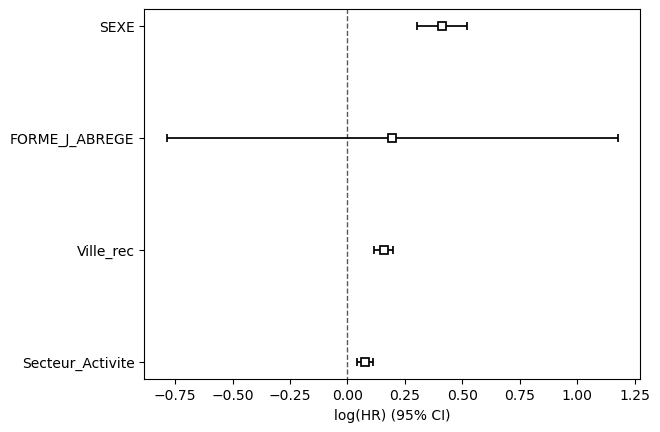

In [182]:
# Initialisation du modèle de Cox
cph = CoxPHFitter()

# Sélection des colonnes pertinentes
survival_data = data[['Duree_Mois', 'ETAT_ARCHIV_REC', 'SEXE', 'FORME_J_ABREGE', 'Ville_rec', 'Secteur_Activite']]

# Encodage des variables catégorielles
# Dictionnaire de recodage numérique pour chaque variable
recodage = {
    'SEXE': {'Homme': 1, 'Femme': 2},  # Sexe : 1 pour Homme, 2 pour Femme
    'FORME_J_ABREGE': {'Personne physique': 1, 'Personne morale': 2},  # Personne physique = 1, Personne morale = 2
    'Ville_rec': {'Grandes villes': 1, 'Villes moyennes': 2, 'Petites villes et autres': 3 },  # Recodage des villes
    'Secteur_Activite': {'Réparation et Commerce': 1, 'Industrie Chimique et Matériaux': 2, 
                         'Autres': 3, 'Fabrication': 4, 'Services Divers': 5, 
                         'Agriculture et Agroalimentaire': 6}  # Recodage des secteurs d'activité
}

# Appliquer le recodage numérique pour chaque variable
for column, mapping in recodage.items():
    survival_data[column] = survival_data[column].map(mapping)
# Ajustement du modèle

cph.fit(survival_data, duration_col='Duree_Mois', event_col='ETAT_ARCHIV_REC')

# Résumé du modèle
cph.print_summary()

# Vérification de la proportionnalité des risques
cph.check_assumptions(survival_data)

# Visualisation des résultats
cph.plot()
plt.show()


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 121382 total observations, 118616 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
FORME_J_ABREGE   km              3.35   0.07      3.90
                 rank            3.80   0.05      4.28
SEXE             km             13.93 <0.005     12.36
                 rank           20.98 <0.005     17.72
Secteur_Activite km              0.82   0.37      1.45
                 rank            2.14   0.14      2.80
Ville_rec        km             10.04 <0.005      9.35
                 rank           36.45 <0.005     29.25



1. Variable 'SEXE' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['SEXE', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Ville_rec' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Ville_rec', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariate

[[<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0002)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0514)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0671)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0015)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1436)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3658)'>]]

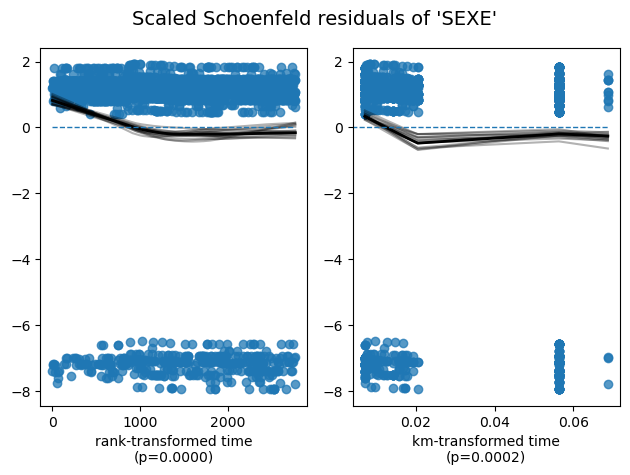

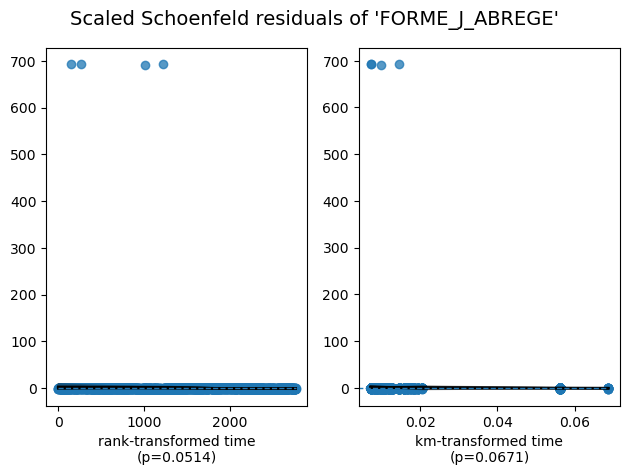

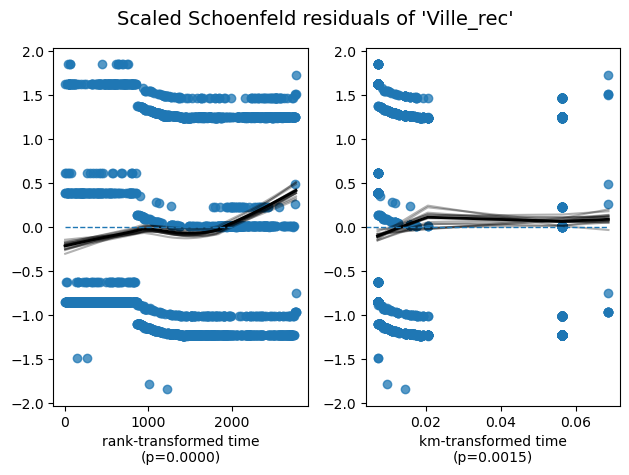

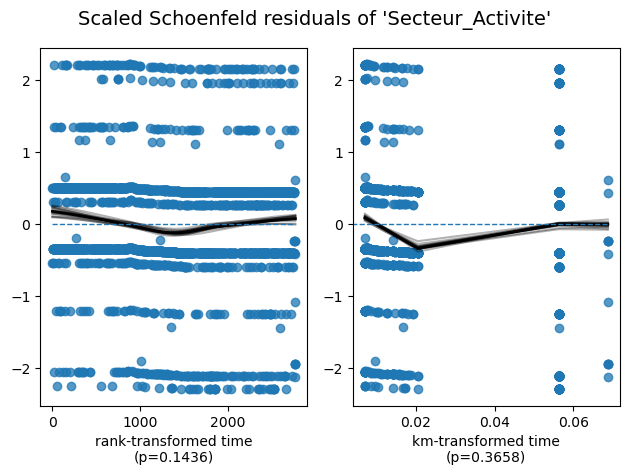

In [186]:
cph.check_assumptions(survival_data, show_plots=True)

## Stratification

In [188]:
# Ajustement du modèle avec stratification

cph.fit(survival_data, duration_col='Duree_Mois', event_col='ETAT_ARCHIV_REC',strata=['Ville_rec','SEXE'])

# Résumé du modèle
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 121382 total observations, 118616 right-censored observations>
             duration col = 'Duree_Mois'
                event col = 'ETAT_ARCHIV_REC'
                   strata = ['Ville_rec', 'SEXE']
      baseline estimation = breslow
   number of observations = 121382
number of events observed = 2766
   partial log-likelihood = -26125.84
         time fit was run = 2024-11-27 17:38:35 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
FORME_J_ABREGE    0.19      1.21      0.50           -0.79            1.17                0.45                3.21
Secteur_Activite  0.08      1.08      0.02            0.04            0.11                1.05                1.12

                  cmp to    z      p  -log2(p)
covariate                                     
FORME_J_ABREGE      0.00 0.37   0.71      0.50
Secteur_Activite    0.00 4.48 <0.005     17.01
---
Concordance = 0.55
Partial AIC = 52255.69
log-likelihood ratio test = 20.07 on 2 df
-log2(p) of ll-ratio test = 14.48

### separation des données en variables explicatives et variables expliquées

In [111]:
X=data.loc[:, 'REGIME':'Secteur_Activite'].assign(Duree_mois=data['Duree_Mois'])
Y=data['ETAT_ARCHIV']

### constitution de l'echantillon


In [114]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)

In [116]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Identifiez les colonnes catégoriques et numériques
categorical_columns = x_train.select_dtypes(include=['object', 'category']).columns
numerical_columns = x_train.select_dtypes(exclude=['object', 'category']).columns

# Appliquer le OneHotEncoder sur les colonnes catégoriques
encoder = OneHotEncoder(sparse_output=False)  # Utiliser sparse_output=False pour obtenir un array dense
encoded_categorical = encoder.fit_transform(x_train[categorical_columns])

# Convertir les données encodées en DataFrame
encoded_categorical_df = pd.DataFrame(
    encoded_categorical, 
    columns=encoder.get_feature_names_out(categorical_columns),
    index=x_train.index
)

# Combiner les colonnes numériques et encodées
x_train = pd.concat([x_train[numerical_columns], encoded_categorical_df], axis=1)

# Vérifier les dimensions
print(x_train.shape)


(84967, 23)


In [118]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Appliquer le OneHotEncoder sur les colonnes catégoriques
encoder = OneHotEncoder(sparse_output=False)  # Utiliser sparse_output=False pour obtenir un array dense
encoded_categorical = encoder.fit_transform(X[categorical_columns])

# Convertir les données encodées en DataFrame
encoded_categorical_df = pd.DataFrame(
    encoded_categorical, 
    columns=encoder.get_feature_names_out(categorical_columns),
    index=X.index
)

# Combiner les colonnes numériques et encodées
X = pd.concat([X[numerical_columns], encoded_categorical_df], axis=1)

# Vérifier les dimensions
print(X.shape)


(121382, 23)


In [120]:
X

,Duree_mois,REGIME_CMD,REGIME_CME,FORME_J_ABREGE_Personne morale,FORME_J_ABREGE_Personne physique,SEXE_Femme,SEXE_Homme,Ville_Autres,Ville_Banfora,Ville_Bobo-Dioulasso,...,Ville_Koudougou,Ville_Ouagadougou,Ville_Ouahigouya,Ville_Tenkodogo,Secteur_Activite_Agriculture et Agroalimentaire,Secteur_Activite_Autres,Secteur_Activite_Fabrication,Secteur_Activite_Industrie Chimique et Matériaux,Secteur_Activite_Réparation et Commerce,Secteur_Activite_Services Divers
0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,29,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,38,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121377,38,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
121378,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
121379,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
121380,38,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## instanciation des modele

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [123]:
knn=KNeighborsClassifier()
rf = RandomForestClassifier(random_state=43)
lr = LogisticRegression()
pr=Perceptron()
arbreFirst = DecisionTreeClassifier()
xbg = XGBClassifier(random_state=42)

### entrainement du modele avec les données d'apprentissage

In [129]:
rf.fit(x_train, y_train)
lr.fit(x_train, y_train)
knn.fit(x_train, y_train)
pr.fit(x_train, y_train)
arbreFirst.fit(x_train, y_train)
#xbg.fit(x_train, y_train)



DecisionTreeClassifier()

###  validation croisée

In [132]:
from sklearn.model_selection import cross_val_score, KFold

In [134]:
models=[knn,lr,rf,pr,arbreFirst,xbg]
for model in models:
    scores = cross_val_score(model, x_train, y_train, cv=5)
    print(f"{model}:{scores.mean()}")

KNeighborsClassifier():0.973142660401235


C:\Users\SAWADOGO\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression():0.976885143901821
RandomForestClassifier(random_state=43):0.9767792179323042
Perceptron():0.9029017431258047
DecisionTreeClassifier():0.9767556829833932


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SAWADOGO\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SAWADOGO\anaconda\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\SAWADOGO\anaconda\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['ACTIF' 'INACTIF']


### recherche de meilleurs parametres

In [136]:
#parametres du modele KNN
n_neighbors=[1,3,9,11,13,17]
weights=['uniform', 'distance']
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']

In [138]:
hyperMatrix = dict(weights=weights, algorithm=algorithm,n_neighbors=n_neighbors)


In [140]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=knn, param_grid=hyperMatrix)
grid_result = grid.fit(x_train, y_train)

# Afficher les meilleurs paramètres
print(f"Best:{grid_result.best_score_}  using {grid_result.best_params_}")

KeyboardInterrupt: 

In [ ]:
#definition du dictionnaire des hyperparametres
hyperMatrix = dict(C=C, penalty=penalty,solver=solver,multi_class=multi_class)

In [ ]:
grid = GridSearchCV(estimator=lr, param_grid=hyperMatrix)
grid_result = grid.fit(x_train, y_train)

# Afficher les meilleurs paramètres
print(f"Best:{grid_result.best_score_}  using {grid_result.best_params_}")

In [ ]:
## parametres du random forest

In [ ]:
n_estimators=[100, 200, 300, 400]
max_depth=[None, 10, 20, 30]
min_samples_split=[2, 5, 10]
min_samples_leaf=[1, 2, 4]
max_features=['auto', 'sqrt']


In [ ]:
hyperMatrix = dict(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features)


In [ ]:
grid = GridSearchCV(estimator=rf, param_grid=hyperMatrix)
grid_result = grid.fit(x_train, y_train)

# Afficher les meilleurs paramètres
print(f"Best:{grid_result.best_score_}  using {grid_result.best_params_}")

### le meilleur modele est : la regression logistic avec les parametres suivants:  {'C': 1000, 'penalty': 'l2'}

# Question 2

In [ ]:

lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1000, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [ ]:
lr.fit(X, Y)

In [173]:
y_pred=lr.predict(X)
print(y_pred)

NameError: name 'lr' is not defined

In [65]:
# Calculer la précision
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y, y_pred)
print(f'Précision du modèle: {accuracy*100}%')

Précision du modèle: 97.7212436769867%


# Question 3

In [45]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [48]:
colonne=pd.DataFrame({"Y_predric":y_pred})
colonne.to_csv("C:/Fabrice_LPAS/fichier/S5/machin/Challenge_classification/y_predit.csv",index=False)

## Taux de survie en fonction des caracteristique

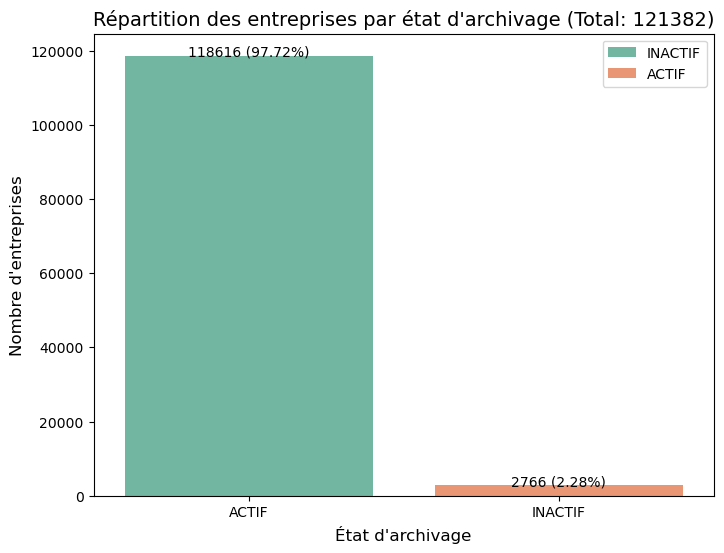

<Figure size 640x480 with 0 Axes>

In [39]:

# Distribution des entreprises par ETAT_ARCHIV
total_lignes = data.shape[0]
counts = data['ETAT_ARCHIV'].value_counts()
percentages = (counts / total_lignes) * 100
counts_with_percentages = counts.map(str) + " (" + percentages.round(2).astype(str) + "%)"

# Créer la palette de couleurs
palette = sns.color_palette("Set2", n_colors=len(counts))

# Visualisation
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette=palette,hue=data['ETAT_ARCHIV'].unique())

# Ajouter les pourcentages au-dessus des barres
for i, (count, percentage) in enumerate(zip(counts.values, percentages)):
    plt.text(i, count + 0.5, f"{count} ({percentage:.2f}%)", ha='center', fontsize=10)

# Ajouter les titres et légendes
plt.title(f"Répartition des entreprises par état d'archivage (Total: {total_lignes})", fontsize=14)
plt.xlabel("État d'archivage", fontsize=12)
plt.ylabel("Nombre d'entreprises", fontsize=12)
plt.show()
plt.savefig('C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archivage_colore.pdf', format='pdf')


Test du Chi² :
Statistique Chi² = 57.0331, p-valeur = 0.0000, degrés de liberté = 1


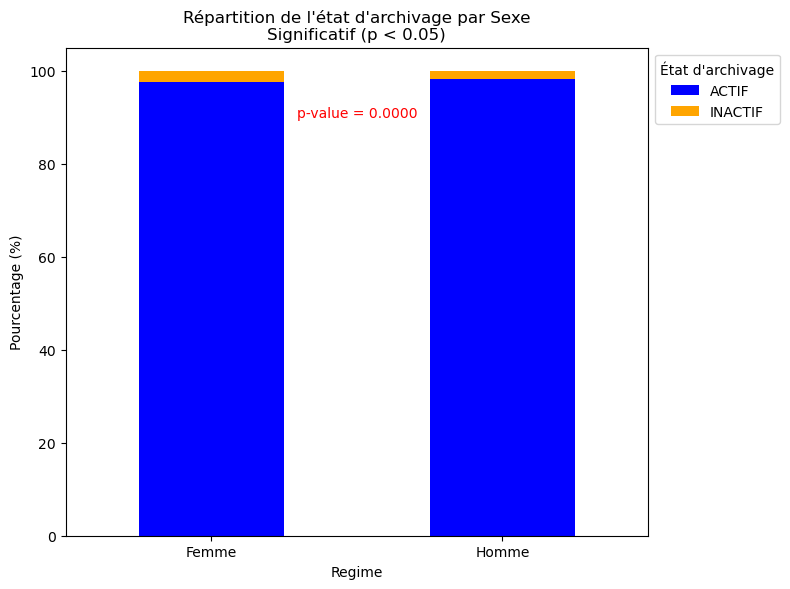

L'image a été enregistrée avec succès à : C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_sexe.pdf


In [57]:

# Tableau croisé
contingency_table = pd.crosstab(data['SEXE'], data['ETAT_ARCHIV'])

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats du test
print(f"Test du Chi² :")
print(f"Statistique Chi² = {chi2:.4f}, p-valeur = {p_value:.4f}, degrés de liberté = {dof}")

# Vérification de la significativité
if p_value < 0.05:
    significativity = "Significatif (p < 0.05)"
else:
    significativity = "Non significatif (p >= 0.05)"

# Calcul des pourcentages pour chaque modalité
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Création du graphique
ax = contingency_pct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['blue', 'orange'])

# Ajout du titre et des légendes
plt.title("Répartition de l'état d'archivage par Sexe\n" + significativity)
plt.xlabel("Regime")
plt.ylabel("Pourcentage (%)")
plt.legend(title="État d'archivage", loc='upper left', bbox_to_anchor=(1, 1))  # Ajustement de la légende
plt.xticks(rotation=0)  # Garde les noms des modalités horizontaux

# Affichage de la p-valeur sur le graphique
plt.text(0.5, 90, f"p-value = {p_value:.4f}", fontsize=10, color="red", ha='center')

# Sauvegarde du graphique avec un format compatible pour LaTeX et haute résolution
output_path = 'C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_sexe.pdf'
plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.tight_layout()  # Ajuste la mise en page pour éviter que des éléments ne soient coupés
plt.show()

# Confirmation que l'image a été sauvegardée avec succès
print(f"L'image a été enregistrée avec succès à : {output_path}")


Test du Chi² :
Statistique Chi² = 384.7633, p-valeur = 0.0000, degrés de liberté = 1


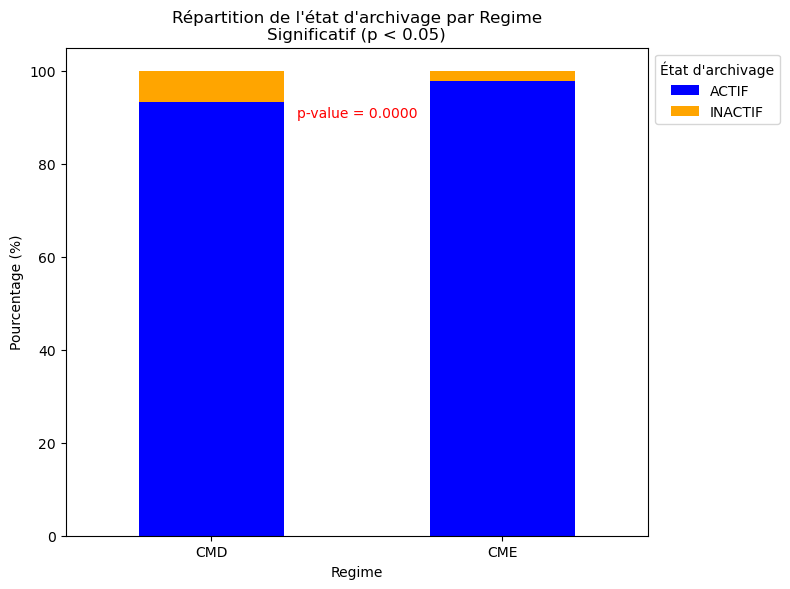

L'image a été enregistrée avec succès à : C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_regime.pdf


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Tableau croisé
contingency_table = pd.crosstab(data['REGIME'], data['ETAT_ARCHIV'])

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats du test
print(f"Test du Chi² :")
print(f"Statistique Chi² = {chi2:.4f}, p-valeur = {p_value:.4f}, degrés de liberté = {dof}")

# Vérification de la significativité
if p_value < 0.05:
    significativity = "Significatif (p < 0.05)"
else:
    significativity = "Non significatif (p >= 0.05)"

# Calcul des pourcentages pour chaque modalité
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Création du graphique
ax = contingency_pct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['blue', 'orange'])

# Ajout du titre et des légendes
plt.title("Répartition de l'état d'archivage par Regime\n" + significativity)
plt.xlabel("Regime")
plt.ylabel("Pourcentage (%)")
plt.legend(title="État d'archivage", loc='upper left', bbox_to_anchor=(1, 1))  # Ajustement de la légende
plt.xticks(rotation=0)  # Garde les noms des modalités horizontaux

# Affichage de la p-valeur sur le graphique
plt.text(0.5, 90, f"p-value = {p_value:.4f}", fontsize=10, color="red", ha='center')

# Sauvegarde du graphique avec un format compatible pour LaTeX et haute résolution
output_path = 'C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_regime.pdf'
plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.tight_layout()  # Ajuste la mise en page pour éviter que des éléments ne soient coupés
plt.show()

# Confirmation que l'image a été sauvegardée avec succès
print(f"L'image a été enregistrée avec succès à : {output_path}")


Test du Chi² :
Statistique Chi² = 264.1940, p-valeur = 0.0000, degrés de liberté = 5


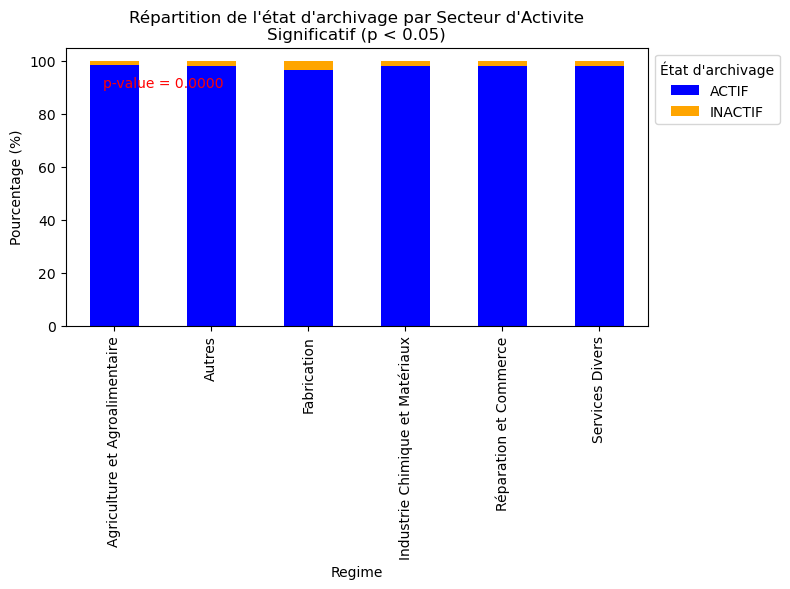

L'image a été enregistrée avec succès à : C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_Secteur_Activite.pdf


In [75]:
# Tableau croisé
contingency_table = pd.crosstab(data['Secteur_Activite'], data['ETAT_ARCHIV'])

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats du test
print(f"Test du Chi² :")
print(f"Statistique Chi² = {chi2:.4f}, p-valeur = {p_value:.4f}, degrés de liberté = {dof}")

# Vérification de la significativité
if p_value < 0.05:
    significativity = "Significatif (p < 0.05)"
else:
    significativity = "Non significatif (p >= 0.05)"

# Calcul des pourcentages pour chaque modalité
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Création du graphique
ax = contingency_pct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['blue', 'orange'])

# Ajout du titre et des légendes
plt.title("Répartition de l'état d'archivage par Secteur d'Activite\n" + significativity)
plt.xlabel("Regime")
plt.ylabel("Pourcentage (%)")
plt.legend(title="État d'archivage", loc='upper left', bbox_to_anchor=(1, 1))  # Ajustement de la légende
plt.xticks(rotation=90)  # Garde les noms des modalités horizontaux

# Affichage de la p-valeur sur le graphique
plt.text(0.5, 90, f"p-value = {p_value:.4f}", fontsize=10, color="red", ha='center')

# Sauvegarde du graphique avec un format compatible pour LaTeX et haute résolution
output_path = 'C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_Secteur_Activite.pdf'
plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.tight_layout()  # Ajuste la mise en page pour éviter que des éléments ne soient coupés
plt.show()

# Confirmation que l'image a été sauvegardée avec succès
print(f"L'image a été enregistrée avec succès à : {output_path}")


Test du Chi² :
Statistique Chi² = 1706.6013, p-valeur = 0.0000, degrés de liberté = 9


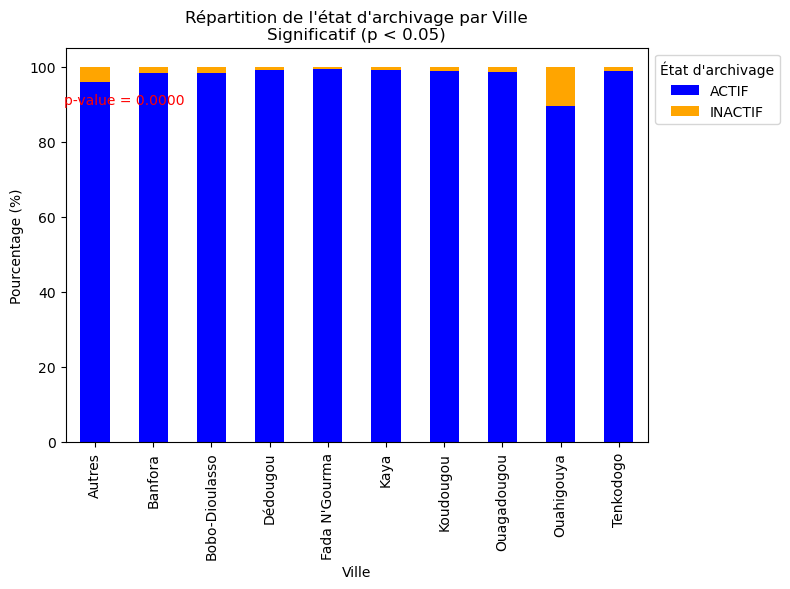

L'image a été enregistrée avec succès à : C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_Ville.pdf


In [77]:
# Tableau croisé
contingency_table = pd.crosstab(data['Ville'], data['ETAT_ARCHIV'])

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats du test
print(f"Test du Chi² :")
print(f"Statistique Chi² = {chi2:.4f}, p-valeur = {p_value:.4f}, degrés de liberté = {dof}")

# Vérification de la significativité
if p_value < 0.05:
    significativity = "Significatif (p < 0.05)"
else:
    significativity = "Non significatif (p >= 0.05)"

# Calcul des pourcentages pour chaque modalité
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Création du graphique
ax = contingency_pct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['blue', 'orange'])

# Ajout du titre et des légendes
plt.title("Répartition de l'état d'archivage par Ville\n" + significativity)
plt.xlabel("Ville")
plt.ylabel("Pourcentage (%)")
plt.legend(title="État d'archivage", loc='upper left', bbox_to_anchor=(1, 1))  # Ajustement de la légende
plt.xticks(rotation=90)  # Garde les noms des modalités horizontaux

# Affichage de la p-valeur sur le graphique
plt.text(0.5, 90, f"p-value = {p_value:.4f}", fontsize=10, color="red", ha='center')

# Sauvegarde du graphique avec un format compatible pour LaTeX et haute résolution
output_path = 'C:/Users/SAWADOGO/Desktop/graphiques/repartition_etat_archive_Ville.pdf'
plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.tight_layout()  # Ajuste la mise en page pour éviter que des éléments ne soient coupés
plt.show()

# Confirmation que l'image a été sauvegardée avec succès
print(f"L'image a été enregistrée avec succès à : {output_path}")


## Analyse de la repartition des caracteristique


In [95]:
import pandas as pd
from prettytable import PrettyTable

# Exemple de DataFrame (remplacer par vos propres données)
# data = pd.read_csv('votre_fichier.csv')

# Liste des variables à exclure
exclude_columns = ['NIFU', 'ETAT_ARCHIV']

# Sélection des colonnes catégorielles, en excluant celles spécifiées
categorical_columns = [col for col in data.select_dtypes(include=['object', 'category']).columns if col not in exclude_columns]

# Initialisation d'un dictionnaire pour stocker les proportions
proportion_dict = {}

# Calcul des proportions pour chaque variable catégorielle
for col in categorical_columns:
    proportion_table = data[col].value_counts(normalize=True) * 100
    proportion_dict[col] = proportion_table

# Convertir le dictionnaire en DataFrame pour un affichage plus facile
proportion_summary = pd.DataFrame(proportion_dict)

# Transposer le DataFrame pour avoir les modalités comme lignes et les variables comme colonnes
proportion_summary = proportion_summary.T

# Création du tableau avec PrettyTable
table = PrettyTable()

# Ajouter la colonne 'Variable' pour chaque ligne, mais avec un seul nom de variable répété pour chaque modalité
table.field_names = ['Variable', 'Modalité', 'Proportion (%)']

# Remplir le tableau avec les données
for col in proportion_summary.columns:
    for index, value in proportion_summary[col].iteritems():
        # Si la variable est déjà ajoutée, ne pas répéter le nom
        table.add_row([col if index == proportion_summary[col].index[0] else "", index, f"{value:.2f}%"])

# Afficher le tableau
print(table)

# Optionnel : pour un affichage graphique avec Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(proportion_summary.T, annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title("Proportions des Variables Catégorielles")
plt.tight_layout()
plt.show()

# Exportation du tableau vers LaTeX
latex_code = proportion_summary.to_latex(index=True, header=True, float_format="%.2f")
with open("tableau_proportions.tex", "w") as f:
    f.write(latex_code)


AttributeError: 'Series' object has no attribute 'iteritems'

## coefficients de la regression logistique

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from prettytable import PrettyTable


X = data[['var1', 'var2', 'var3', 'var4']]  # Remplacez par vos variables
y = data['ETAT_ARCHIV']  # La variable cible (binaire : 0 ou 1)

X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# Créer et entraîner le modèle de régression logistique
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Calculer l'exponentielle des coefficients (odds ratios)
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)

# Ajout d'une constante à X pour le modèle statsmodels
X_train_with_intercept = sm.add_constant(X_train_scaled)

# Créer un modèle statsmodels pour obtenir les p-values
model = sm.Logit(y_train, X_train_with_intercept)
result = model.fit()

# Extraire les p-values
p_values = result.pvalues[1:]  # Ignorer la p-value de l'intercept

# Créer un tableau PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Coefficient", "Exponentielle (Odds Ratio)", "p-value"]

# Remplir le tableau avec les données
for var, coef, odds, p_val in zip(X.columns, coefficients, odds_ratios, p_values):
    table.add_row([var, f"{coef:.4f}", f"{odds:.4f}", f"{p_val:.4f}"])

# Afficher le tableau
print(table)

# Exporter sous LaTeX
latex_code = table.get_latex_string()
print("\nCode LaTeX du tableau:")
print(latex_code)

# Sauvegarder le code LaTeX dans un fichier
with open("table_logistic_regression.tex", "w") as f:
    f.write(latex_code)


## Evaluation du modele

In [143]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [147]:
conf_matrix = confusion_matrix(Y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()

# 2. Métriques
accuracy = accuracy_score(Y, y_pred)
precision = precision_score(Y, y_pred)
recall = recall_score(Y, y_pred)
f1 = f1_score(Y, y_pred)
roc_auc = roc_auc_score(Y, y_proba)

# 3. Rapport de classification
print("Rapport de Classification :")
print(classification_report(Y, y_pred))

# 4. Affichage des métriques
print(f"Précision (Accuracy): {accuracy:.4f}")
print(f"Précision (Precision): {precision:.4f}")
print(f"Rappel (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

NameError: name 'Y' is not defined

### souvagarde du modele

In [196]:
import joblib
# Sauvegarder le modèle ajusté
joblib.dump(lr, 'regression.pkl')

# Charger le modèle plus tard
modele = joblib.load('regression.pkl')

## Analyse bivariee

### creation d'une fonction pour les tests

In [106]:
l=len(data.ETAT_ARCHIV.unique())
c=len(data.SEXE.unique())
N=data.shape[0]
def VCramer(chi2,l,c,N):
  import numpy as np
  mini = min(l-1,c-1)
  return np.sqrt(chi2/N*mini)
 
def Tschuprow(chi2,l,c,N):
  import numpy as np
  return np.sqrt(chi2/N*(l-1)*(c-1))
 
def var_qual_vs_cible(df,noms_var,nom_cible,seuil):
  from scipy.stats import chi2_contingency
  import pandas as pd 
  pvalue=[]
  V=[]
  T=[]
  for var in noms_var:
    tableau_contingence=pd.DataFrame( pd.crosstab(df[var], 
                                  df[nom_cible],  
                                  margins = False))
    chi2, p= chi2_contingency(tableau_contingence)[0:2]
    pvalue.append(p)
    V.append(VCramer(chi2,l,c,N))
    T.append(Tschuprow(chi2,l,c,N))
 
  dic={"variable":noms_var,"pvalue":pvalue,"VCramer":V,"Tschuprow":T}
  res=pd.DataFrame(dic)
  return res

In [108]:
noms_var=["SEXE","REGIME","FORME_J_ABREGE","Ville", "Secteur_Activite"]
var_qual_vs_cible(data,noms_var,"ETAT_ARCHIV",0.05)

,variable,pvalue,VCramer,Tschuprow
0,SEXE,4.285282e-14,0.021676,0.021676
1,REGIME,1.142701e-85,0.056301,0.056301
2,FORME_J_ABREGE,6.166584e-01,0.001437,0.001437
3,Ville,0.000000e+00,0.118574,0.118574
4,Secteur_Activite,4.938769e-55,0.046654,0.046654


**SEXE :** p-value extrêmement faible, indiquant une association statistiquement significative. Toutefois, la valeur de VCramer (0.0217) indique une association très faible en termes de force.

**REGIME :** p-value très faible également, significative. Cependant, l'association mesurée par VCramer reste faible (0.0563).

**FORME_J_ABREGE :** p-value élevée (0.6167), indiquant que l'association n'est pas significative. Le VCramer est très faible (0.0014), confirmant l'absence de relation.

**Ville :** p-value nulle (dans les limites de la précision), ce qui signifie une association hautement significative. Le VCramer (0.1186) indique une force d'association modérée.

**Secteur_Activite :** p-value très faible, association significative, mais la force de la relation reste faible (VCramer = 0.0467).